<a href="https://colab.research.google.com/github/PedroJuiz/SupervisedLearning/blob/main/Health_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

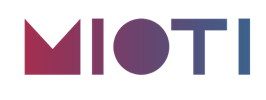
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S7 : Control de salud

## Objetivo

El objetivo de este challenge es entrenar un modelo para determinar el estado de salud de una persona en funcion de unas variables tomadas de la monitorizacion de 50 personas durante 31 dias tomando muestras cada hora del numero de pulsaciones por minuto, asi como el sexo, la edad y el peso de la persona. La etiqueta a predecir es el estado de salud (OK o BAD)en cada hora.


In [ ]:
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC




### Entrenamiento del modelo

Dispones de un dataset `health.csv` que contiene varias variables y su relación con el estado de salud del paciente (emergencia o situación normal).

Analiza, preprocesalo y entrena un modelo para luego utilizarlo más adelante. Aplica lo consideres más relevante para este caso de lo que has aprendido durante la asignatura.

### Carga del dataset

In [ ]:
df = pd.read_csv('health_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37200 entries, 0 to 37199
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      37200 non-null  int64  
 1   sex     37200 non-null  int64  
 2   age     37200 non-null  int64  
 3   weight  37200 non-null  float64
 4   day     37200 non-null  object 
 5   hour    37200 non-null  int64  
 6   bpm     37200 non-null  int64  
 7   status  37200 non-null  object 
dtypes: float64(1), int64(5), object(2)
memory usage: 2.3+ MB


In [ ]:
df.head()

,id,sex,age,weight,day,hour,bpm,status
0,0,1,48,92.7,2007-12-01,0,95,OK
1,0,1,48,92.7,2007-12-01,1,100,OK
2,0,1,48,92.7,2007-12-01,2,107,OK
3,0,1,48,92.7,2007-12-01,3,97,OK
4,0,1,48,92.7,2007-12-01,4,97,OK


In [ ]:
df.shape  # (24*31*50 , 8)

(37200, 8)

In [ ]:
df['date'] = (df['day'].map(str) + ' ' + df['hour'].map(str) + ':00:00')
df.head()

,id,sex,age,weight,day,hour,bpm,status,date
0,0,1,48,92.7,2007-12-01,0,95,OK,2007-12-01 0:00:00
1,0,1,48,92.7,2007-12-01,1,100,OK,2007-12-01 1:00:00
2,0,1,48,92.7,2007-12-01,2,107,OK,2007-12-01 2:00:00
3,0,1,48,92.7,2007-12-01,3,97,OK,2007-12-01 3:00:00
4,0,1,48,92.7,2007-12-01,4,97,OK,2007-12-01 4:00:00


In [ ]:
df = df.drop(['day', 'hour'], axis = 1)
df.head()

,id,sex,age,weight,bpm,status,date
0,0,1,48,92.7,95,OK,2007-12-01 0:00:00
1,0,1,48,92.7,100,OK,2007-12-01 1:00:00
2,0,1,48,92.7,107,OK,2007-12-01 2:00:00
3,0,1,48,92.7,97,OK,2007-12-01 3:00:00
4,0,1,48,92.7,97,OK,2007-12-01 4:00:00


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37200 entries, 0 to 37199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      37200 non-null  int64         
 1   sex     37200 non-null  int64         
 2   age     37200 non-null  int64         
 3   weight  37200 non-null  float64       
 4   bpm     37200 non-null  int64         
 5   status  37200 non-null  object        
 6   date    37200 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.0+ MB


In [ ]:
df.head()

,id,sex,age,weight,bpm,status,date
0,0,1,48,92.7,95,OK,2007-12-01 00:00:00
1,0,1,48,92.7,100,OK,2007-12-01 01:00:00
2,0,1,48,92.7,107,OK,2007-12-01 02:00:00
3,0,1,48,92.7,97,OK,2007-12-01 03:00:00
4,0,1,48,92.7,97,OK,2007-12-01 04:00:00


In [ ]:
df = df.set_index('date')
df.head()

,id,sex,age,weight,bpm,status
date,,,,,,
2007-12-01 00:00:00,0,1,48,92.7,95,OK
2007-12-01 01:00:00,0,1,48,92.7,100,OK
2007-12-01 02:00:00,0,1,48,92.7,107,OK
2007-12-01 03:00:00,0,1,48,92.7,97,OK
2007-12-01 04:00:00,0,1,48,92.7,97,OK


# Analizar los datos

* ¿Los datos tienen estructura de serie temporal? ¿Puedes hacer una grafica de la evolucion de bpm a lo largo de todos los dias para una persona?

* Elige que atributos pueden ser utiles para un modelo de clasificacion. Elimina los que no sean utiles.
* Crea la matriz de datos de entrenamiento: X e y, y divide los datos en entrenamiento y test

In [ ]:
¿Los datos tienen estructura de serie temporal?

Si, en ellos podemos apreciar como avanza la salud de cada persona a lo largo de un mes.



In [ ]:
#¿Puedes hacer una grafica de la evolucion de bpm a lo largo de todos los dias para una persona?
df_person = df[df['id'] == 0]
df_person = df_person['bpm']
df_person.head()

date
2007-12-01 00:00:00     95
2007-12-01 01:00:00    100
2007-12-01 02:00:00    107
2007-12-01 03:00:00     97
2007-12-01 04:00:00     97
Name: bpm, dtype: int64

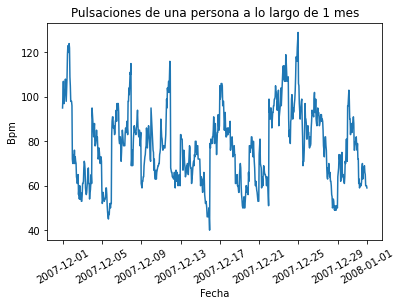

In [ ]:
plt.plot(df_person)
plt.title('Pulsaciones de una persona a lo largo de 1 mes')
plt.xlabel('Fecha')
plt.ylabel('Bpm')
plt.xticks(rotation = 30)
plt.show()

In [ ]:
#Elige que atributos pueden ser utiles para un modelo de clasificacion. Elimina los que no sean utiles.
df_modelo = df.drop('id', axis = 1)
df_modelo.head()

,sex,age,weight,bpm,status
date,,,,,
2007-12-01 00:00:00,1,48,92.7,95,OK
2007-12-01 01:00:00,1,48,92.7,100,OK
2007-12-01 02:00:00,1,48,92.7,107,OK
2007-12-01 03:00:00,1,48,92.7,97,OK
2007-12-01 04:00:00,1,48,92.7,97,OK


In [ ]:
df_modelo['status'] = df_modelo['status'].replace({'OK': 1, 'BAD': 0})

In [ ]:
#Crea la matriz de datos de entrenamiento: X e y, y divide los datos en entrenamiento y test
dataset_y = df_modelo['status']
dataset_X = df_modelo[['sex', 'age', 'weight', 'bpm']]

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=123)

# Entrenamiento sin ajustar los hiperparametros

* Entrena 3 modelos con los datos obtenidos anteriormente
* Presenta los resultados sobre los conjuntos de entrenamiento y test

## XGBoost

In [ ]:
import xgboost as xgb

xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_hat = xgboost.predict(X_test)

In [ ]:
accu = accuracy_score(y_test, y_hat)
prec = precision_score(y_test, y_hat, average='weighted')
recall = recall_score(y_test, y_hat, average='weighted')
f1 = f1_score(y_test, y_hat, average='weighted')

print(f'Accuracy: {accu}\nPrecision_score: {prec}\nRecall_score: {recall}\nF1_score: {f1}')

Accuracy: 0.996594982078853
Precision_score: 0.9966587626318064
Recall_score: 0.996594982078853
F1_score: 0.9966242826444273


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_hat = rfc.predict(X_test)

In [ ]:
accu = accuracy_score(y_test, y_hat)
prec = precision_score(y_test, y_hat, average='weighted')
recall = recall_score(y_test, y_hat, average='weighted')
f1 = f1_score(y_test, y_hat, average='weighted')

print(f'Accuracy: {accu}\nPrecision_score: {prec}\nRecall_score: {recall}\nF1_score: {f1}')

Accuracy: 0.9966845878136201
Precision_score: 0.9967636725308401
Recall_score: 0.9966845878136201
F1_score: 0.9967200936644932


## SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [ ]:
y_hat = svc.predict(X_test)

In [ ]:
accu = accuracy_score(y_test, y_hat)
prec = precision_score(y_test, y_hat, average='weighted')
recall = recall_score(y_test, y_hat, average='weighted')
f1 = f1_score(y_test, y_hat, average='weighted')

print(f'Accuracy: {accu}\nPrecision_score: {prec}\nRecall_score: {recall}\nF1_score: {f1}')

Accuracy: 0.9958781362007169
Precision_score: 0.9956282571404044
Recall_score: 0.9958781362007169
F1_score: 0.9955654820508094


# Entrenamiento ajustando los hiperparametros

* Ajusta los parámetros de los 3 modelos anteriores realizando una busqueda en al menos dos parametros.
* Presenta los resultados sobre los conjuntos de entrenamiento y test

## XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

xgb = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb, params, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5]})

In [ ]:
# Obtener los mejores parámetros y puntuaciones
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprimir los mejores parámetros y puntuaciones
print(f'Best parameters: {best_params}')
print(f'Best accuracy: {best_score}')

# Obtener la precisión del modelo optimizado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')

Best parameters: {'learning_rate': 0.1, 'max_depth': 3}
Best accuracy: 0.9958141321044547
Test accuracy: 0.9973118279569892


## Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y puntuaciones
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprimir los mejores parámetros y puntuaciones
print(f'Best parameters: {best_params}')
print(f'Best accuracy: {best_score}')

# Obtener la precisión del modelo optimizado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best accuracy: 0.9958141321044547
Test accuracy: 0.9968637992831542


## SVM

In [ ]:
svm_model = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.1, 1, 10, 'scale']
}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y puntuaciones
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprimir los mejores parámetros y puntuaciones
print(f'Best parameters: {best_params}')
print(f'Best accuracy: {best_score}')

# Obtener la precisión del modelo optimizado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')

# Conclusiones

* Que conclusiones obtienes
* Tiempos de entrenamiento?
* Merece siempre la pena?

In [ ]:
Se observa que los modelos con los hiperparámetros default ya ofrecen unos resultados muy buenos, sin apenas diferencias entre ellos. Por lo tanto, considero que la parte de fine tuning de hiperparámetros, teniendo en cuenta el tiempo de búsqueda de los hiperparámetros óptimos y el coste computacional, en este caso se podría haber omitido.

También es posible que las métricas de evaluación den unos resultados tan altos debido al desbalanceo de los datos, ya que tenemos muchos más casos en los que hay un status de 'OK' que de 'BAD'.